In [159]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator

In [160]:
path = "myData" 
labelFile = 'labels.csv'
batch_size_val = 20 
steps_per_epoch_val = 400
epochs_val = 100
imageDimesions = (32,32,3)
testRatio = 0.2    
validationRatio = 0.2

In [161]:
images = []
target = []
dirList = os.listdir(path)
noOfClasses = len(dirList)
print("Total Classes: ", len(dirList))
print("Importing Classes...")

for x in range(noOfClasses):
    pictureList = os.listdir(os.path.join(path, str(x)))
    for y in pictureList:
        img = cv2.imread(os.path.join(path, str(x), str(y)))
        images.append(img)
        target.append(x)
    print(x, end = " ")

images = np.array(images)
target = np.array(target)

Total Classes:  43
Importing Classes...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 

In [162]:
X_train, X_test, y_train, y_test = train_test_split(images, target, test_size = testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = validationRatio)

In [163]:
print("Data Shapes")
print("Train",end = "")
print(X_train.shape,y_train.shape)
print("Validation",end = "")
print(X_validation.shape,y_validation.shape)
print("Test",end = "")
print(X_test.shape,y_test.shape)
assert(X_train.shape[0] == y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert(X_validation.shape[0] == y_validation.shape[0]), "The number of images in not equal to the number of lables in validation set"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert(X_train.shape[1:] == (imageDimesions))," The dimesions of the Training images are wrong "
assert(X_validation.shape[1:] == (imageDimesions))," The dimesionas of the Validation images are wrong "
assert(X_test.shape[1:] == (imageDimesions))," The dimesionas of the Test images are wrong"

Data Shapes
Train(22271, 32, 32, 3) (22271,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)


In [164]:
data = pd.read_csv(labelFile)
print("Data shape:", data.shape, type(data))

Data shape: (43, 2) <class 'pandas.core.frame.DataFrame'>


In [165]:
# Show sample of training images
# num_of_samples = []
# cols = 5
# fig, axs = plt.subplots(nrows = noOfClasses, ncols = cols, figsize = (5, 100))
# fig.tight_layout()
# for i in range(cols):
#     for j, row in data.iterrows():
        # x_selected = X_train[y_train == j]
        # axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap = plt.get_cmap("gray"))
        # axs[j][i].axis("off")
        # if i == 2:
            # axs[j][i].set_title(str(j) + "-"+ row["Name"])
            # num_of_samples.append(len(x_selected))

[114, 1246, 1288, 833, 1123, 1016, 229, 830, 810, 873, 1185, 756, 1207, 1251, 444, 339, 231, 638, 694, 115, 182, 172, 221, 280, 169, 827, 336, 125, 307, 158, 251, 458, 126, 385, 221, 700, 199, 121, 1158, 184, 199, 136, 134]


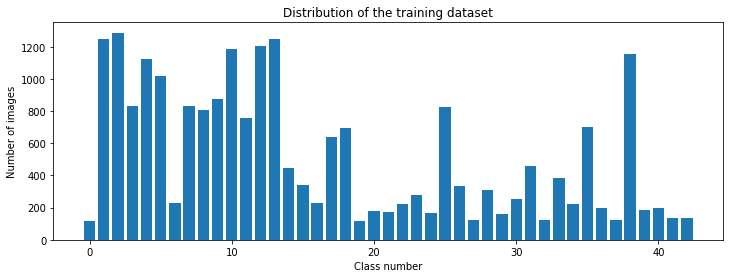

In [166]:
num_of_samples = [len(X_train[y_train == i]) for i in range(noOfClasses)]
print(num_of_samples)

plt.figure(figsize = (12, 4))
plt.bar(range(0, noOfClasses), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [167]:
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

def sobel(img):
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    grad = np.sqrt(grad_x ** 2 + grad_y ** 2)
    img = (grad * 255 / grad.max()).astype(np.uint8)
    return img

def preprocessing(img):
    img = grayscale(img)
    # img = equalize(img)
    img = sobel(img)
    img = img / 255       
    return img

In [168]:
X_train = np.array(list(map(preprocessing,X_train))) 
X_validation = np.array(list(map(preprocessing,X_validation)))
X_test = np.array(list(map(preprocessing,X_test)))

In [169]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [170]:
dataGen = ImageDataGenerator(width_shift_range = 0.1,   # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                            height_shift_range = 0.1,
                            zoom_range = 0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                            shear_range = 0.1,  # MAGNITUDE OF SHEAR ANGLE
                            rotation_range = 10)  # DEGREES
dataGen.fit(X_train)
batches = dataGen.flow(X_train,y_train,batch_size = 20)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch,y_batch = next(batches)

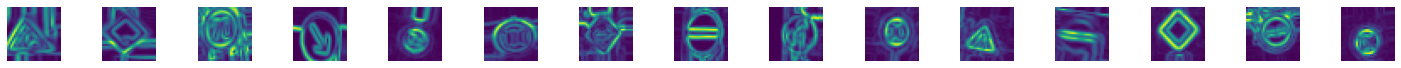

In [171]:
fig,axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimesions[0], imageDimesions[1]))
    axs[i].axis('off')
plt.show()

In [172]:
y_train = to_categorical(y_train,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)

In [173]:
def myModel():
    no_Of_Filters=60
    size_of_Filter=(5,5) # THIS IS THE KERNEL THAT MOVE AROUND THE IMAGE TO GET THE FEATURES.
                         # THIS WOULD REMOVE 2 PIXELS FROM EACH BORDER WHEN USING 32 32 IMAGE
    size_of_Filter2=(3,3)
    size_of_pool=(2,2)  # SCALE DOWN ALL FEATURE MAP TO GERNALIZE MORE, TO REDUCE OVERFITTING
    no_Of_Nodes = 500   # NO. OF NODES IN HIDDEN LAYERS
    model= Sequential()
    model.add((Conv2D(no_Of_Filters,size_of_Filter,input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool)) # DOES NOT EFFECT THE DEPTH/NO OF FILTERS

    model.add((Conv2D(no_Of_Filters//2, size_of_Filter2,activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(no_Of_Nodes,activation='relu'))
    model.add(Dropout(0.5)) # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
    model.add(Dense(noOfClasses,activation='softmax')) # OUTPUT LAYER
    # COMPILE MODEL
    model.compile(Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [174]:
model = myModel()
print(model.summary())
history=model.fit_generator(dataGen.flow(X_train,y_train,batch_size=batch_size_val),steps_per_epoch=steps_per_epoch_val,epochs=epochs_val,validation_data=(X_validation,y_validation),shuffle=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 4, 4, 30)         

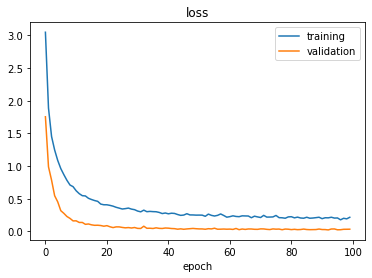

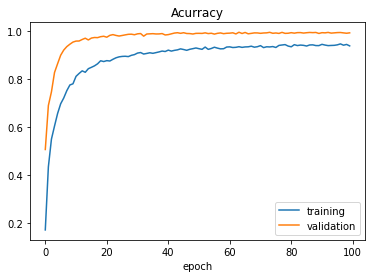

Test Score: 0.03636405989527702
Test Accuracy: 0.9892241358757019


In [175]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])

In [176]:
model.save('trained_model')

INFO:tensorflow:Assets written to: trained_model/assets
